<a href="https://colab.research.google.com/github/Bryncs/Challenge_Data_Science_2_Alura/blob/main/Modelo_de_Recomenda%C3%A7%C3%A3o.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparando o Ambiente

Nesta primeira parte iremos instalar o PySpark e preparar nosso DataSet para depois iniciar a criação de nosso modelo de recomendação

## Instalando o PySpark

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Importando a classe SparkSession

In [2]:
from pyspark.sql import SparkSession

In [3]:
spark = SparkSession.builder\
    .appName('Recomendador InsightPlaces')\
    .getOrCreate()
spark

## Importando os Dados

Preparando o Drive

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Importando os dados

In [5]:
import zipfile

In [6]:
zipfile.ZipFile('/content/drive/MyDrive/InsightPlaces3/semanas-3-e-4.zip', 'r').extractall('/content/drive/MyDrive/InsightPlaces3')

In [7]:
path = '/content/drive/MyDrive/InsightPlaces3/dataset_ml_parquet'
dados = spark.read.parquet(path)

# Preparando os Dados

In [8]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: double (nullable = true)
 |-- vaga: double (nullable = true)
 |-- bairro: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zona Sul: integer (nullable = true)
 |-- Academia: integer (nullable = true)
 |-- Animais permitidos: integer (nullable = true)
 |-- Churrasqueira: integer (nullable = true)
 |-- Condomínio fechado: integer (nullable = true)
 |-- Elevador: integer (nullable = true)
 |-- Piscina: integer (nullable = true)
 |-- Playground: integer (nullable = true)
 |-- Portaria 24h: integer (nullable = true)
 |-- Portão eletrônico: integer (nullable 

## Nomes das Colunas

Há nomes de colunas com letras maiúsculas, acentos e espaços então primeiramente iremos tratá-los para, caso necessário, trabalhar mais facilmente com o Dataset

In [9]:
nomes_antigos = dados.columns
nomes_antigos

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'bairro',
 'condominio',
 'iptu',
 'valor',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul',
 'Academia',
 'Animais permitidos',
 'Churrasqueira',
 'Condomínio fechado',
 'Elevador',
 'Piscina',
 'Playground',
 'Portaria 24h',
 'Portão eletrônico',
 'Salão de festas']

In [10]:
nomes_novos = [
    'id',
    'andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'bairro',
    'condominio',
    'iptu',
    'valor',
    'zona_central',
    'zona_norte',
    'zona_oeste',
    'zona_sul',
    'academia',
    'animais_permitidos',
    'churrasqueira',
    'condominio_fechado',
    'elevador',
    'piscina',
    'playground',
    'portaria_24h',
    'portao_eletronico',
    'salao_de_festas'
]

In [11]:
colunas_nomes = zip(nomes_antigos, nomes_novos)

In [12]:
for antigos, novos in colunas_nomes:
  dados = dados.withColumnRenamed(antigos, novos)

In [13]:
dados.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'bairro',
 'condominio',
 'iptu',
 'valor',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_de_festas']

# Vetorização

## Visualizando os dados

In [14]:
from pyspark.sql import functions as f

In [15]:
dados.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_de_festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|Santo Cristo|     100.0|100.0|245000.0|           1|         0|     

Como podemos observar não há valores nulos

In [16]:
dados\
    .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dados.columns])\
    .show()

+---+-----+---------+---------+-------+------+----+------+----------+----+-----+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
| id|andar|area_util|banheiros|quartos|suites|vaga|bairro|condominio|iptu|valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_de_festas|
+---+-----+---------+---------+-------+------+----+------+----------+----+-----+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|  0|    0|        0|        0|      0|     0|   0|     0|         0|   0|    0|           0|         0|         0|       0|       0|                 0|            0|                 0|       0|      0|         0|    

Tamanho do nosso DataSet

In [17]:
linhas = dados.count()
colunas = len(dados.columns)
print(f'Este DataFrame contém {linhas} linhas e {colunas} colunas')

Este DataFrame contém 66551 linhas e 25 colunas


## Iniciando a vetorização

Como podemos observar as colunas id e bairro são strings, para vetorização, será necessário realizar algum tratamento ou retira-las para criar o modelo, neste modelo irei optar pela remoção

In [18]:
dados.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: integer (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: double (nullable = true)
 |-- vaga: double (nullable = true)
 |-- bairro: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)
 |-- zona_central: integer (nullable = true)
 |-- zona_norte: integer (nullable = true)
 |-- zona_oeste: integer (nullable = true)
 |-- zona_sul: integer (nullable = true)
 |-- academia: integer (nullable = true)
 |-- animais_permitidos: integer (nullable = true)
 |-- churrasqueira: integer (nullable = true)
 |-- condominio_fechado: integer (nullable = true)
 |-- elevador: integer (nullable = true)
 |-- piscina: integer (nullable = true)
 |-- playground: integer (nullable = true)
 |-- portaria_24h: integer (nullable = true)
 |-- portao_eletronico: integer (nullable 

O método VectorAssembler junta os dados das colunas indicadas em uma coluna que utilizamos como vetor

In [19]:
from pyspark.ml.feature import VectorAssembler

In [20]:
dados.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'bairro',
 'condominio',
 'iptu',
 'valor',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_de_festas']

In [21]:
X = dados.columns
X.remove('id')
X.remove('bairro')
X

['andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul',
 'academia',
 'animais_permitidos',
 'churrasqueira',
 'condominio_fechado',
 'elevador',
 'piscina',
 'playground',
 'portaria_24h',
 'portao_eletronico',
 'salao_de_festas']

Com o seguinte método realizamos a vetorização dos nosso dados numéricos e mantemos as colunas id e bairro no nosso modelo

In [22]:
dados_vector = VectorAssembler(inputCols = X, outputCol = 'features').transform(dados).select(['features', 'id', 'bairro'])

In [23]:
dados_vector.show(truncate = False, n = 5)

+------------------------------------------------------------------------------------------------------------+------------------------------------+------------+
|features                                                                                                    |id                                  |bairro      |
+------------------------------------------------------------------------------------------------------------+------------------------------------+------------+
|[2.0,35.0,1.0,1.0,0.0,0.0,100.0,100.0,245000.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]     |00002dd9-cc74-4809-b5a5-850adf0e7526|Santo Cristo|
|(23,[0,1,2,3,5,6,7,8,10,15,17,19,20,22],[1.0,84.0,2.0,2.0,1.0,770.0,105.0,474980.0,1.0,1.0,1.0,1.0,1.0,1.0])|0009ca94-2b37-4381-b8b8-773ce0f92444|Tijuca      |
|(23,[1,2,3,6,7,8,12,14,17],[85.0,2.0,2.0,460.0,661.0,290000.0,1.0,1.0,1.0])                                 |000e3d28-e3e5-4110-b488-69154931140e|Santa Teresa|
|(23,[1,2,3,5,6,7,8,11,18,19],[58.

# Padronizando os Dados

O método StandardScaler transforma os dados das linhas vetorizadas do nosso dataset em valores padronizados ou seja as escalas deles serão semelhantes

In [24]:
from pyspark.ml.feature import StandardScaler

In [25]:
scaler = StandardScaler(inputCol='features', outputCol='scaled_features') # Padroniza os dados vetorizados
scaler_model = scaler.fit(dados_vector) # Ajusta os dados vetorizados
dados_scaler = scaler_model.transform(dados_vector) # Transforma o modelo ajustado/padronizado

In [26]:
dados_scaler.show(truncate = False, n = 5)

+------------------------------------------------------------------------------------------------------------+------------------------------------+------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|features                                                                                                    |id                                  |bairro      |scaled_features                                                                                                                                                                                                                                                                                                             

# Redução de Dimensionalidade

Encontrando o número ideal de Componentes

In [27]:
from pyspark.ml.feature import PCA

In [28]:
k = len(X)

In [29]:
pca = PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')
model_pca = pca.fit(dados_scaler)

In [30]:
lista_valores = [sum(model_pca.explainedVariance[0:i+1]) for i in range(k)]

In [31]:
import numpy as np

In [32]:
k = sum(np.array(lista_valores) <= 0.7)
k

6

In [33]:
pca = PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')
model_pca = pca.fit(dados_scaler)
dados_pca = model_pca.transform(dados_scaler)

In [34]:
dados_pca.select('pca_features').show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]    |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]       |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]    |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828] |
|[-0.4181406070145923,-2.131040791141693,-0.1026409926497008,2.809916415039177,-0.042956284698168964,-0.09449068767336

# Criando um Pipeline

Para facilitar futuras transformações nos dados irei utilizar um Pipeline que basicamente é o conjunto de aplicações aplicados anteriormente (VectorAssembler, StandardScaler e Pca)

In [35]:
from pyspark.ml import Pipeline

In [36]:
pca_pipeline = Pipeline(stages = [VectorAssembler(inputCols = X, outputCol = 'features'),
                                  StandardScaler(inputCol='features', outputCol='scaled_features'),
                                  PCA(k = k, inputCol = 'scaled_features', outputCol = 'pca_features')])

In [37]:
pca_pipeline_model = pca_pipeline.fit(dados)

In [38]:
dados_pca = pca_pipeline_model.transform(dados)

In [39]:
dados_pca.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+--------------------+--------------------+--------------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_de_festas|            features|     scaled_features|        pca_features|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+-----------

Como podemos observar chegamos ao mesmo resultado, só que com uma maior facilidade

In [40]:
dados_pca.select('pca_features').show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------+
|pca_features                                                                                                               |
+---------------------------------------------------------------------------------------------------------------------------+
|[-6.165125049533812,1.3380985269405696,-1.7052299823820158,-0.5338289630560162,0.08903815478581815,-0.3134396180129953]    |
|[-3.2529111812184865,-1.1179591836228857,-0.2923895841501507,3.195538820020636,0.1528630698219846,1.302893049066197]       |
|[-1.0611769329629537,-1.6685040058694294,-2.30759482783911,0.10553124125788461,-0.06914386452866851,0.7187181899556143]    |
|[-1.995811900783872,-1.7655796610847843,1.3571962498672347,-0.16336519381168974,-0.021305227846957334,0.12808044918214828] |
|[-0.4181406070145923,-2.131040791141693,-0.1026409926497008,2.809916415039177,-0.042956284698168964,-0.09449068767336

# Criando Clusters

In [41]:
from pyspark.ml.clustering import KMeans

In [42]:
SEED = 156

## Encontrando uma quantidade ideal de clusters

Vamos analisar os valores entre 2 e 30

In [43]:
i = {}

for k in range(2, 30):
  kmeans_dados = KMeans(featuresCol = 'pca_features', k = k, seed = SEED)
  model = kmeans_dados.fit(dados_pca)
  i[k] = model.summary.trainingCost

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

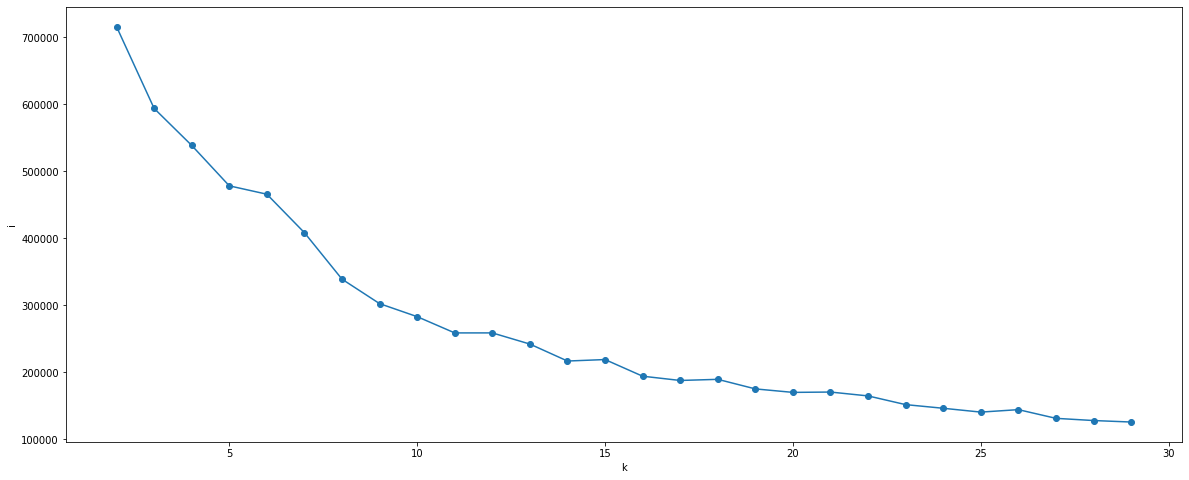

In [45]:
fig, ax = plt.subplots(1, 1, figsize =(20, 8))

ax.plot(list(i.keys()), list(i.values()),**{'marker': 'o'})
ax.set_xlabel('k')
ax.set_ylabel('i')
plt.show()

Aparentemente 11 clusters parece o número correto pois a curva diminui a partir deste ponto

In [46]:
kmeans = KMeans(k = 11, featuresCol = 'pca_features', predictionCol = 'cluster_pca', seed = SEED)

Agora utilizando os dados criados em nosso Pipeline podemos continuar a criação de nosso modelo

In [47]:
kmeans_model = kmeans.fit(dados_pca)

In [48]:
kmeans_predictions = kmeans_model.transform(dados_pca)

In [49]:
kmeans_predictions.select(['pca_features', 'cluster_pca']).show()

+--------------------+-----------+
|        pca_features|cluster_pca|
+--------------------+-----------+
|[-6.1651250495338...|          1|
|[-3.2529111812184...|         10|
|[-1.0611769329629...|          0|
|[-1.9958119007838...|          4|
|[-0.4181406070145...|          3|
|[-6.9015238649802...|          9|
|[-0.7164221492881...|          3|
|[-1.4856960209870...|          3|
|[-6.0456283208921...|          9|
|[-6.1992405713781...|         10|
|[-6.8846811115738...|          1|
|[-4.6134703872770...|          6|
|[-4.4763270618055...|          6|
|[-0.9935595784851...|          4|
|[-3.1645192533431...|          8|
|[-3.5460599405485...|          2|
|[-7.5070643480675...|          9|
|[-0.6502007974669...|          3|
|[-0.1271532177362...|          3|
|[-2.8493633914844...|          8|
+--------------------+-----------+
only showing top 20 rows



## Avaliando as informações de cada cluster

### Quantidade de dados em cada cluster

In [50]:
kmeans_predictions.groupBy('cluster_pca').count().orderBy('cluster_pca').show()

+-----------+-----+
|cluster_pca|count|
+-----------+-----+
|          0| 9084|
|          1|14756|
|          2| 3014|
|          3| 6734|
|          4| 7796|
|          5| 2877|
|          6| 6312|
|          7|   27|
|          8| 6375|
|          9| 4743|
|         10| 4833|
+-----------+-----+



A quantidade de dados varia bastante entre os clusters. Os clusters com a diferença mais significante são o 1 com 14756 itens e o 7 com 27 itens

### Média das variáveis dos clusters

In [51]:
clusters_means = kmeans_predictions\
                    .groupBy('cluster_pca')\
                    .mean()

In [52]:
clusters_means.show(5)

+-----------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+------------------+--------------------+--------------------+-----------------------+-------------------+-----------------------+-------------------+-------------------+-------------------+-------------------+----------------------+--------------------+----------------+
|cluster_pca|        avg(andar)|    avg(area_util)|    avg(banheiros)|      avg(quartos)|       avg(suites)|         avg(vaga)|   avg(condominio)|         avg(iptu)|        avg(valor)|   avg(zona_central)|     avg(zona_norte)|   avg(zona_oeste)|       avg(zona_sul)|       avg(academia)|avg(animais_permitidos)| avg(churrasqueira)|avg(condominio_fechado)|      avg(elevador)|       avg(piscina)|    avg(playground)|  avg(portaria_24h)|avg(portao_eletronico)|avg(salao_de_festas)|avg(cluster_pca)|
+-----

In [53]:
colunas_cluster = ['avg(area_util)', 'avg(banheiros)', 'avg(quartos)', 'avg(valor)']
nomes_colunas = ['Área útil', 'Banheiros', 'Quartos', 'Valor']

In [54]:
analise_clusters = zip(colunas_cluster, nomes_colunas)

In [55]:
for col, name in analise_clusters:
  clusters_means\
            .orderBy(col, ascending = False)\
            .withColumn(name, f.round(clusters_means[col],2))\
            .select('cluster_pca', name)\
            .show()

+-----------+---------+
|cluster_pca|Área útil|
+-----------+---------+
|          5|    279.8|
|          7|    260.3|
|          9|   254.33|
|          2|   246.51|
|          0|    98.58|
|          6|    94.83|
|          1|    89.45|
|          4|    88.67|
|          8|    87.37|
|          3|    86.28|
|         10|     75.4|
+-----------+---------+

+-----------+---------+
|cluster_pca|Banheiros|
+-----------+---------+
|          5|     5.02|
|          9|     4.67|
|          2|     3.91|
|          7|     3.63|
|          6|     2.32|
|          1|     2.13|
|          0|     2.06|
|          4|     2.03|
|          3|      2.0|
|         10|     1.86|
|          8|     1.85|
+-----------+---------+

+-----------+-------+
|cluster_pca|Quartos|
+-----------+-------+
|          9|   3.87|
|          5|   3.85|
|          2|    3.7|
|          7|   3.44|
|          6|   2.54|
|          1|   2.45|
|          0|    2.4|
|          3|   2.39|
|          4|   2.36|
|         10| 

Com base nos dados acima percebemos que:

- Os clusters com maior área útil são o 5 e o 7 acima de 260 m2 e os com menor área útil são os 3 e 10 com menos de 90 m2

- Os clusters com maior número de banheiros são o 5 e o 9 com mais de 4 banheiros e os com menor número de banheiros são o 10 e o 8 com menos de 2 banheiros

- Os clusters com maior média de quartos são o 9 e o 5 e os com menor média de quartos são o 10 e o 8

- Os clusters com maior valor são o 2 e o 7 e os com menor valor o 10 e o 3

Analisando essas informações percebemos que: 

- O cluster 10 está nos itens com menores médias

- O cluster 5 apesar de estar no topo da maior parte dos itens selecionados, não é necessáriamente o que contém maiores valores

Já para ter uma maior noção dos demais clusters seria necessário selecionar mais variáveis

# Filtrando imóveis do mesmo cluster

Selecionando o ID de um imóvel

In [58]:
imovel = '00002dd9-cc74-4809-b5a5-850adf0e7526'

Cluster do imóvel

In [60]:
cluster = kmeans_predictions.filter(kmeans_predictions.id == imovel).select('cluster_pca').collect()[0][0]
cluster

1

Imóveis do mesmo cluster

In [61]:
imovel_cluster = kmeans_predictions.filter(kmeans_predictions.cluster_pca == cluster)
print(imovel_cluster.count())
imovel_cluster.show(5)

14756
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+-----+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+--------------------+--------------------+--------------------+-----------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|              bairro|condominio| iptu|    valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_de_festas|            features|     scaled_features|        pca_features|cluster_pca|
+--------------------+-----+---------+---------+-------+------+----+--------------------+----------+-----+---------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+-

# Calculando a distância Euclidiana

In [63]:
from scipy.spatial.distance import euclidean
from pyspark.sql.types import FloatType

Vetor do imóvel

In [64]:
componentes_imovel = kmeans_predictions.filter(kmeans_predictions.id == imovel)\
                                          .select('pca_features').collect()[0][0]
componentes_imovel

DenseVector([-6.1651, 1.3381, -1.7052, -0.5338, 0.089, -0.3134])

UDF = User Defined Function

In [65]:
def calcula_distance(value):
  return euclidean(componentes_imovel, value)

udf_calcula_distance = f.udf(calcula_distance, FloatType())

In [69]:
imoveis_dist = imovel_cluster.withColumn('distancia', udf_calcula_distance('pca_features'))
imoveis_dist.select('id', 'distancia').show(10, truncate = False)

+------------------------------------+---------+
|id                                  |distancia|
+------------------------------------+---------+
|00002dd9-cc74-4809-b5a5-850adf0e7526|0.0      |
|00348cd1-923a-4dbd-b113-b31c7b877bec|2.7919433|
|00779ffc-4566-41f0-8096-fc9d4aab2df2|4.115592 |
|007a7c27-bb0b-4b60-9d14-527010304296|3.4347608|
|0088ef55-9e24-402c-b3bc-dd9fe31a4816|4.1354737|
|00a24367-5bf0-4b79-a587-2326526fbac8|3.669618 |
|00edc0a5-4d9d-4420-b382-3dae14eaa869|4.5104856|
|01064d20-7e1f-4e94-90ef-ad53d0f5f61d|4.8616433|
|011c65c8-d56d-4a91-98c6-64c0f4c04df9|3.9910316|
|0123b5ed-e6b5-4dec-8d02-1fc6c1b4d3f5|2.617254 |
+------------------------------------+---------+
only showing top 10 rows



# Função Recomendadora

In [70]:
def recomendador(imovel_id):
  cluster = kmeans_predictions.filter(kmeans_predictions.id == imovel).select('cluster_pca').collect()[0][0]
  print('Cluster do imóvel', cluster)
  imovel_cluster = kmeans_predictions.filter(kmeans_predictions.cluster_pca == cluster)
  imoveis_dist = imovel_cluster.withColumn('distancia', udf_calcula_distance('pca_features'))
  recomendados = spark.createDataFrame(imoveis_dist.sort('distancia').take(10))
  recomendados.drop('features','scaled_features','pca_features','distancia','cluster_pca').show()

In [71]:
recomendador('00002dd9-cc74-4809-b5a5-850adf0e7526')

Cluster do imóvel 1
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|      bairro|condominio| iptu|   valor|zona_central|zona_norte|zona_oeste|zona_sul|academia|animais_permitidos|churrasqueira|condominio_fechado|elevador|piscina|playground|portaria_24h|portao_eletronico|salao_de_festas|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+-----+--------+------------+----------+----------+--------+--------+------------------+-------------+------------------+--------+-------+----------+------------+-----------------+---------------+
|00002dd9-cc74-480...|    2|       35|        1|      1|   0.0| 0.0|Santo Cristo|     100.0|100.0|245000.0|         